In [1]:
import xarray as xr
import pandas as pd
import seaborn as sns

%matplotlib inline
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score
import scipy.stats
import scipy.optimize as spo

# Load Airpublic sensor data from colocation at MY1 AURN station

In [2]:
# load 
df = pd.read_csv('airpublic_colocation_raw_CO_NO.csv')
df.pm10 = df.pm10.astype(float)
df.timestamp = pd.to_datetime(df.timestamp)
df = df.sort_values(by='timestamp')

In [3]:
df.head().T

,0,1,2,3,4
Unnamed: 0,2141,2140,2139,2138,2137
altitude,0,0,75,81.3,81
gas_temp,32.7,258.2,255,255,258.2
gps_fix,0,0,1,1,1
heading,3,3,152.1,249.4,285.7
humidity,50,51.1,50.4,50.7,50.7
latitude,0.89,0.39,51.5228,51.5229,51.5229
lonet_bat,93,96,92,94,93
longitude,86.4,69.6,-0.15468,-0.15471,-0.154737
pm1,0.538,0.827,4.072,1.905,1.883


# Convert co voltage to ppb


In [4]:
ANALOG_REF_VOLTAGE = 3.3;
    
# AFE board serial number 12-000027
# sensor CO A4 serial number 132950238

CO_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV  = 268;
CO_WORKING_ELECTRODE_SENSOR_ZERO_MV  = 42;

CO_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV  = 262;
CO_AUXILIARY_ELECTRODE_SENSOR_ZERO_MV  = 10;
CO_SENSITIVITY = 0.285; # mv/ppb

def convert_co(CO_working_mv=None, CO_aux_mv=None, temp_correction = +1):
    scaled_working_CO_nA = (CO_working_mv - CO_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV) / 0.8
    scaled_aux_CO_nA  =  (CO_aux_mv - CO_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV) / 0.8 * temp_correction
    return (scaled_working_CO_nA - scaled_aux_CO_nA) / CO_SENSITIVITY

In [5]:
df['co_ppb'] = df[['raw_CO_working','raw_CO_aux']].apply(lambda x: convert_co(x.values[0], x.values[1]), axis=1)

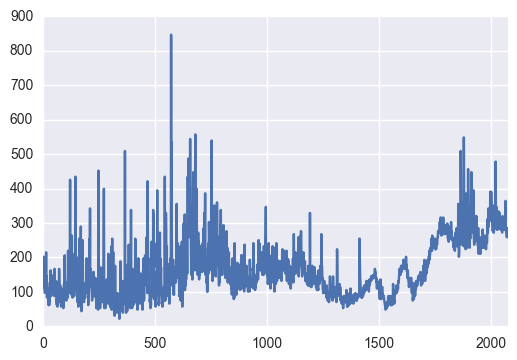

In [6]:
df.co_ppb.plot()

In [7]:
df.co_ppb.describe()

count    2077.000000
mean      163.922294
std        82.212210
min        21.862839
25%       100.935673
50%       144.759171
75%       210.630516
max       846.479532
Name: co_ppb, dtype: float64

## One hour averages

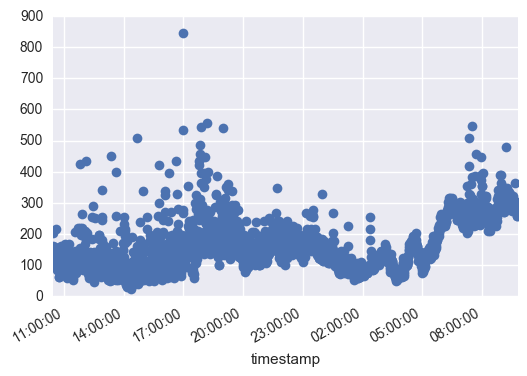

In [8]:
ds = xr.Dataset.from_dataframe(df.set_index('timestamp', 'id'))
ds_mean_1h = ds.resample(freq='1H', dim='timestamp', how='mean', skipna=True)
df.set_index('timestamp').co_ppb.plot(linestyle='none', marker='o')
#ds = ds.set_coords(['timestamp','id'])
#ds = ds.set_coords(['timestamp','id'])

## Compare to kings measurements from MY1 station

In [9]:
# load kings

df_kings_vol = pd.read_csv('my1_volume_18jan.csv')
df_kings_vol['timestamp'] = pd.to_datetime(df_kings_vol.date)

def filter_by_time(df):
    time = (df.timestamp >= '2017-01-17 13:00') & (df.timestamp <= '2017-01-18 12:00')
    return df[time]

# co is in ppm
df_kings_vol.co = 1000 * df_kings_vol.co

df_kings_vol = filter_by_time(df_kings_vol)
df_kings_vol = df_kings_vol.set_index('timestamp')
ds_kings_vol = xr.Dataset.from_dataframe(df_kings_vol)
kings_prefix = dict([(v, 'kings_'+v) for v in ds_kings_vol.data_vars])


def compare(ds_merged, airpublic_measure, kings_measure):
    ds_merged_one = ds_merged[[airpublic_measure, kings_measure]]
    # ds_merged_one['error'] = ds_merged_one[kings_measure] - ds_merged[airpublic_measure]
    #ds_merged_one.sel(datetime=example_date).to_dataframe().plot()
    ds_merged_one.to_dataframe().plot()
    sns.pairplot(ds_merged_one.to_dataframe().dropna().reset_index(), vars=ds_merged_one.data_vars)
    print(ds_merged_one.to_dataframe().describe())
    
    # calculate r2 score
    r2 = r2_score(ds_merged_one.to_dataframe().dropna()[airpublic_measure], ds_merged_one.to_dataframe().dropna()[kings_measure])
    print("r2 score: ", r2)
    
    # KS-test
    ks_statistic, p_value = scipy.stats.ks_2samp(ds_merged_one.to_dataframe().dropna()[airpublic_measure], ds_merged_one.to_dataframe().dropna()[kings_measure])
    print("Probability that they belong to the same distribution (KS p-value): ", p_value)    

In [10]:
ds_kings_vol.to_dataframe().head()

,Unnamed: 0,date,site,nox,no2,o3,so2,co,pm10_raw,pm10,nv10,code
timestamp,,,,,,,,,,,,
2017-01-17 13:00:00,9182,2017-01-17 13:00:00,Westminster - Marylebone Road,NaN,NaN,NaN,NaN,NaN,64.800450,63.372866,NaN,MY1
2017-01-17 14:00:00,9183,2017-01-17 14:00:00,Westminster - Marylebone Road,295.0899,57.658025,8.059500,5.34600,200.0,47.880333,48.438046,NaN,MY1
2017-01-17 15:00:00,9184,2017-01-17 15:00:00,Westminster - Marylebone Road,330.3483,64.011675,7.412750,5.46975,300.0,57.142215,54.528085,NaN,MY1
2017-01-17 16:00:00,9185,2017-01-17 16:00:00,Westminster - Marylebone Road,272.0574,62.759150,7.885375,4.95000,400.0,52.396728,50.716279,NaN,MY1
2017-01-17 17:00:00,9186,2017-01-17 17:00:00,Westminster - Marylebone Road,306.7182,73.067325,7.611750,4.77675,500.0,53.607645,52.445866,NaN,MY1


In [11]:
ds_merged = xr.merge([ds_kings_vol.rename(kings_prefix), ds_mean_1h]
                     , join='inner')

         kings_co      co_ppb
count   19.000000   20.000000
mean   492.543860  164.351785
std    221.803333   59.295664
min    200.000000   88.215761
25%    345.833333  119.280903
50%    450.000000  157.702243
75%    537.500000  198.018024
max    950.000000  281.352190
r2 score:  -1.82291554098
Probability that they belong to the same distribution (KS p-value):  1.0255985535e-07


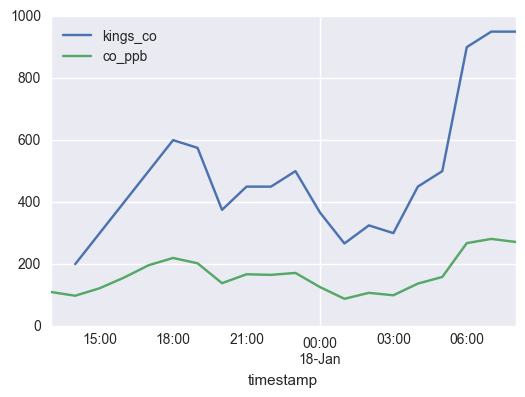

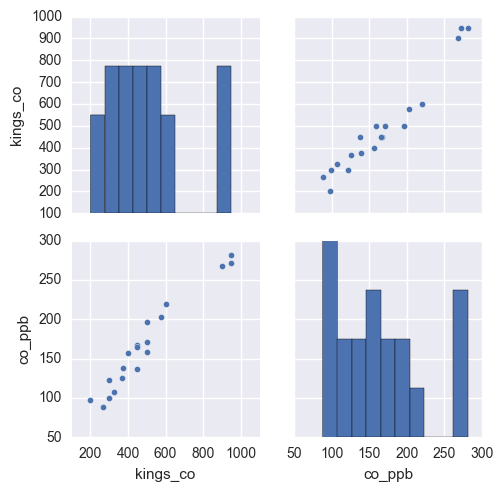

In [12]:
compare(ds_merged, 'kings_co', 'co_ppb')

## Fudge factors using linear regression

### Random split

Coefficients: 
 [[ 3.70960952]] [-121.7004159]
Mean squared error: 4056.71
Variance score: 0.29
R2 score: 0.878


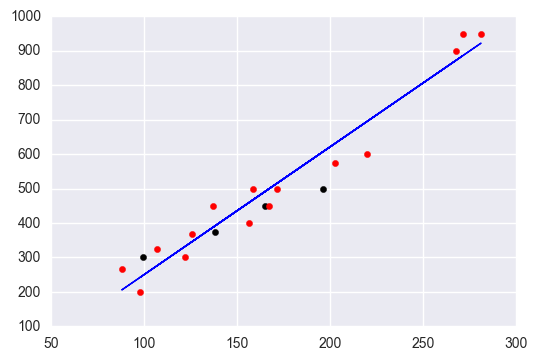

In [13]:
# drop nan values for our use
ds_merged_temp = ds_merged.to_dataframe().dropna(subset=['kings_co'])

# split the data into training and test sets
kings_train, kings_test, co_train, co_test = train_test_split(ds_merged_temp.kings_co, ds_merged_temp.co_ppb, test_size=0.2)

# convenience function for reshaping for use in sklearn linear regression
def reshape(xarray_col):
    return xarray_col.values.reshape((len(xarray_col.values), 1))


# probably should refactor this into a function...
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(reshape(co_train), reshape(kings_train))
# co_train.values.shape
# The coefficients
print('Coefficients: \n', regr.coef_, regr.intercept_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regr.predict(reshape(co_test)) - reshape(kings_test)) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(reshape(co_test), reshape(kings_test)))
scores = cross_val_score(regr, reshape(co_test), reshape(kings_test), scoring='r2')
print("R2 score: %.3f" % scores[0])

plt.scatter(co_test, kings_test,  color='black')
plt.scatter(co_train, kings_train, color='red')
plt.plot(reshape(co_train), regr.predict(reshape(co_train)), color='blue',
         linewidth=1)
plt.show()

### Chronological split

Coefficients: 
 [[ 3.20859811]] [-90.91557497]
Mean squared error: 11190.94
Variance score: 0.85
R2 score: 0.807


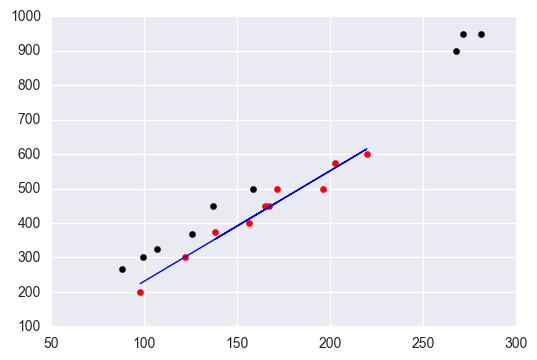

In [14]:
def chronological_split(df_xcol, df_ycol, test_size=0.2):
    assert len(df_xcol) == len(df_ycol)
    test_number = int(test_size * len(df_xcol))
    train_number = len(df_xcol) - test_number
    return df_xcol.head(train_number), df_xcol.tail(test_number), df_ycol.head(train_number), df_ycol.tail(test_number)

# split the data into training and test sets
kings_train2, kings_test2, co_train2, co_test2 = chronological_split(ds_merged_temp.kings_co, ds_merged_temp.co_ppb, test_size=0.5)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(reshape(co_train2), reshape(kings_train2))
# co_train.values.shape
# The coefficients
print('Coefficients: \n', regr.coef_, regr.intercept_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regr.predict(reshape(co_test2)) - reshape(kings_test2)) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(reshape(co_test2), reshape(kings_test2)))
scores = cross_val_score(regr, reshape(co_test2), reshape(kings_test2), scoring='r2')
print("R2 score: %.3f" % scores[0])

plt.scatter(co_test2, kings_test2,  color='black')
plt.scatter(co_train2, kings_train2, color='red')
plt.plot(reshape(co_train2), regr.predict(reshape(co_train2)), color='blue',
         linewidth=1)
plt.show()

         kings_co  co_ppb_modified
count   19.000000        20.000000
mean   492.543860       436.423250
std    221.803333       190.255955
min    200.000000       192.133348
25%    345.833333       291.808903
50%    450.000000       415.087544
75%    537.500000       544.444682
max    950.000000       811.830530
r2 score:  0.880721169885
Probability that they belong to the same distribution (KS p-value):  0.741505714203


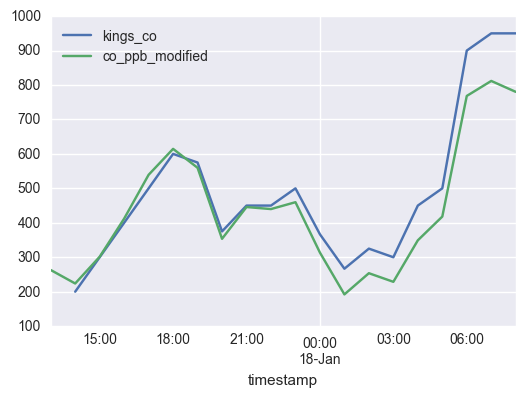

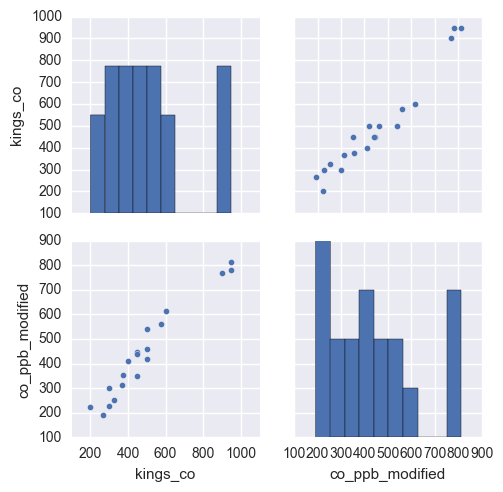

In [15]:
ds_merged['co_ppb_modified'] = ds_merged['co_ppb'] * regr.coef_[0] + regr.intercept_[0]

compare(ds_merged,'kings_co','co_ppb_modified')

## Fudge factors by fitting to the original formula

In [16]:
def convert_co_model(raw_CO, CO_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV, CO_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV, 
                     CO_SENSITIVITY, PCB_GAIN):
    CO_working_mv, CO_aux_mv = raw_CO
    temp_correction = 1
    scaled_working_CO_nA = (CO_working_mv - CO_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV) / PCB_GAIN
    scaled_aux_CO_nA  =  (CO_aux_mv - CO_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV) / PCB_GAIN * temp_correction
    return (scaled_working_CO_nA - scaled_aux_CO_nA) / CO_SENSITIVITY

In [17]:
packed = ds_merged_temp[['raw_CO_working', 'raw_CO_aux']].T.values
packed

array([[ 137.19690443,  142.36496162,  150.14517671,  159.48146272,
         165.20357025,  161.38895084,  145.65451852,  152.47808215,
         152.30270902,  154.34063536,  143.2085994 ,  133.90053147,
         138.51552181,  136.38534266,  145.44005328,  150.52144916,
         176.64937729,  179.67779189,  177.5814876 ],
       [ 108.83384349,  108.48573199,  108.40244603,  108.69531631,
         109.06657851,  109.15495219,  108.0740633 ,  108.34161347,
         108.58549836,  109.20620713,  108.46966367,  107.787338  ,
         108.02978355,  107.67685648,  108.17163636,  108.3519569 ,
         109.59425641,  109.52949252,  109.68224793]])

In [18]:
co_popt, co_pcov = spo.curve_fit(convert_co_model, packed, ds_merged_temp.kings_co.values)

# compare fitted values to the given values
print("CO_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV", co_popt[0], " | real: ", CO_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV)
print("CO_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV", co_popt[1], " | real: ", CO_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV)
print("CO_SENSITIVITY", co_popt[2], " | real: ", CO_SENSITIVITY)
print("PCB_GAIN", co_popt[3], " | real: ", str(0.8))

CO_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV 43.4568312984  | real:  268
CO_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV 30.4094493093  | real:  262
CO_SENSITIVITY -0.266089934042  | real:  0.285
PCB_GAIN -0.23709211211  | real:  0.8


       co_ppb_modified    kings_co
count        19.000000   19.000000
mean        492.544273  492.543860
std         215.038165  221.803333
min         207.105120  200.000000
25%         337.017497  345.833333
50%         461.612213  450.000000
75%         609.668995  537.500000
max         905.102020  950.000000
r2 score:  0.936087941395
Probability that they belong to the same distribution (KS p-value):  0.956292329188


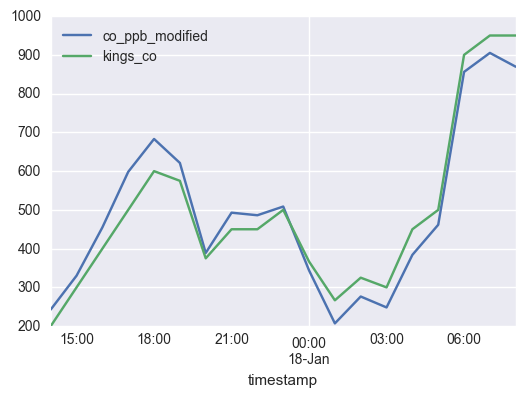

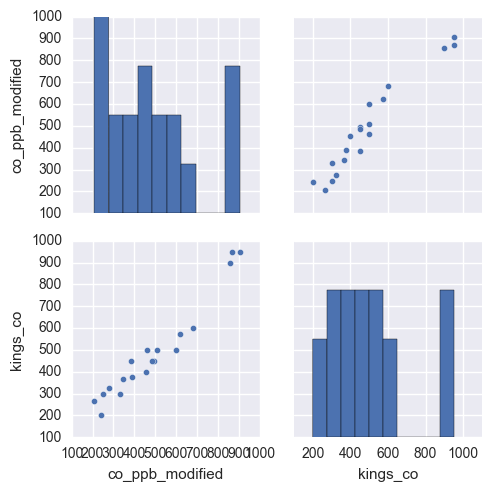

In [19]:
y = convert_co_model(packed, *co_popt)
y.shape
ds_merged_temp['co_ppb_modified'] = convert_co_model(packed, *co_popt)
compare(xr.Dataset.from_dataframe(ds_merged_temp), 'co_ppb_modified', 'kings_co')

## f1 score

In [20]:
# NO2 threshold taken from page 86 of http://www.euro.who.int/__data/assets/pdf_file/0009/128169/e94535.pdf
CO_WHO_THRESHOLD_MICROGRAMS = 10.5 * 10**3 # in micrograms per m3
CO_WHO_THRESHOLD_PPB = CO_WHO_THRESHOLD_MICROGRAMS / 1.145 # convert to ppb
CO_WHO_THRESHOLD_PPB

9170.305676855894

All the readings seem to be well below the threshold...I'll try setting a lower threshold to see the f1 score

In [21]:
CO_WHO_THRESHOLD_PPB = 500

In [22]:
# f1 score without any scaling or translation
# f1_score(co_r2_df.dropna()['kings_co'] > CO_WHO_THRESHOLD_PPB, co_r2_df.dropna()['co_ppb'] > CO_WHO_THRESHOLD_PPB)

In [23]:
# f1 score after some normalization
# f1_score(co_r2_df.dropna()['kings_co'] > CO_WHO_THRESHOLD_PPB, co_r2_df.dropna()['co_ppb_modified'] > CO_WHO_THRESHOLD_PPB)

# NO2 conversion

In [24]:
# AFE board serial number 12-000027
# sensor NO2 A43F serial number 212060336
NO2_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV  = 295;
NO2_WORKING_ELECTRODE_SENSOR_ZERO_MV  = 2;
NO2_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV  = 295;
NO2_AUXILIARY_ELECTRODE_SENSOR_ZERO_MV  = 0;
NO2_SENSITIVITY = -0.271; # mv/ppb

def convert_no2(NO2_working_mv=None, NO2_aux_mv=None, temp_correction = +1.09):
    # temp corretion is +1.09 up to 20 deg Cels, then 1.35, then 3 after 30C    
    
    scaled_working_NO2_nA = (NO2_working_mv - NO2_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV) / -0.73
    scaled_aux_NO2_nA = (NO2_aux_mv - NO2_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV) / -0.73 * temp_correction
    return (scaled_working_NO2_nA -  scaled_aux_NO2_nA ) / NO2_SENSITIVITY

In [25]:
df['no2_ppb'] = df[['raw_NO2_working','raw_NO2_aux']].apply(lambda x: convert_no2(x.values[0], x.values[1]), axis=1)

In [26]:
df.no2_ppb.describe()

count    2077.000000
mean      102.480442
std         8.157926
min        77.795389
25%        98.481212
50%       103.048782
75%       108.068090
max       154.459044
Name: no2_ppb, dtype: float64

## One hour averages

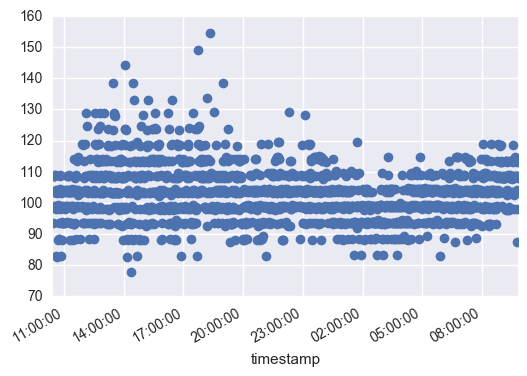

In [27]:
ds = xr.Dataset.from_dataframe(df.set_index('timestamp', 'id'))
ds_mean_1h = ds.resample(freq='1H', dim='timestamp', how='mean', skipna=True)
df.set_index('timestamp').no2_ppb.plot(linestyle='none', marker='o')

## Compare to Kings

In [28]:
ds_merged = xr.merge([ds_kings_vol.rename(kings_prefix), ds_mean_1h]
                     , join='inner')

       kings_no2     no2_ppb
count  19.000000   20.000000
mean   52.392931  102.333472
std     9.749879    3.311235
min    36.768175   96.162712
25%    45.259812   99.838735
50%    51.498600  102.558593
75%    58.665725  104.852244
max    73.067325  107.383791
r2 score:  -26.9485410378
Probability that they belong to the same distribution (KS p-value):  1.56592343815e-09


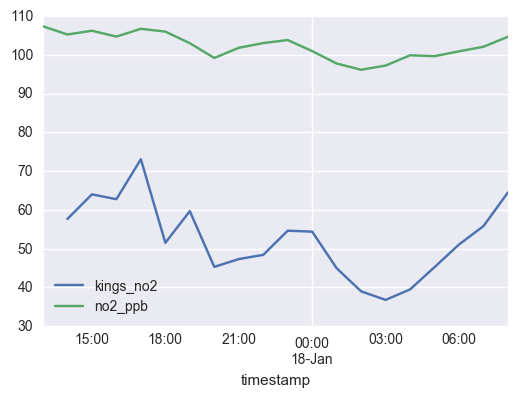

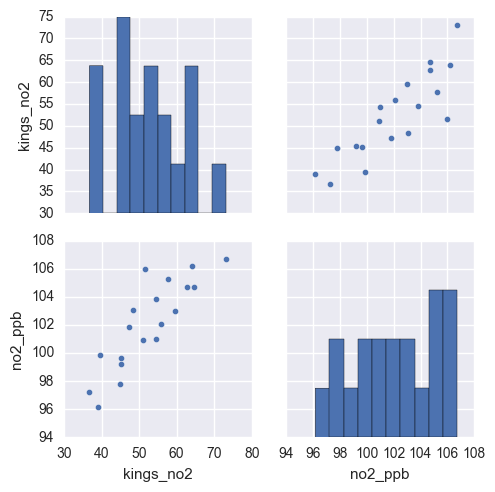

In [29]:
compare(ds_merged, 'kings_no2', 'no2_ppb')

## Fudge factors using linear regression

### Random split

Coefficients: 
 [[ 2.43794329]] [-196.43888202]
Mean squared error: 24.93
Variance score: 0.74
R2 score: -15.977


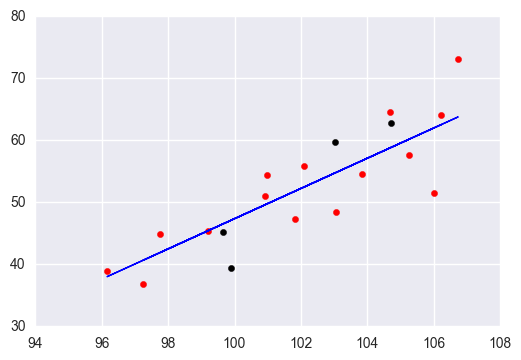

In [30]:
# drop nan values for our use
ds_merged_temp = ds_merged.to_dataframe().dropna(subset=['kings_no2'])

# split the data into training and test sets
kings_train, kings_test, no2_train, no2_test = train_test_split(ds_merged_temp.kings_no2, ds_merged_temp.no2_ppb, test_size=0.2)

# convenience function for reshaping for use in sklearn linear regression
def reshape(xarray_col):
    return xarray_col.values.reshape((len(xarray_col.values), 1))

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(reshape(no2_train), reshape(kings_train))
# co_train.values.shape
# The coefficients
print('Coefficients: \n', regr.coef_, regr.intercept_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regr.predict(reshape(no2_test)) - reshape(kings_test)) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(reshape(no2_test), reshape(kings_test)))
scores = cross_val_score(regr, reshape(no2_test), reshape(kings_test), scoring='r2')
print("R2 score: %.3f" % scores[0])

plt.scatter(no2_test, kings_test,  color='black')
plt.scatter(no2_train, kings_train, color='red')
plt.plot(reshape(no2_train), regr.predict(reshape(no2_train)), color='blue',
         linewidth=1)
plt.show()

### Chronological split

Coefficients: 
 [[ 2.83648165]] [-238.52870686]
Mean squared error: 22.61
Variance score: 0.70
R2 score: -0.303


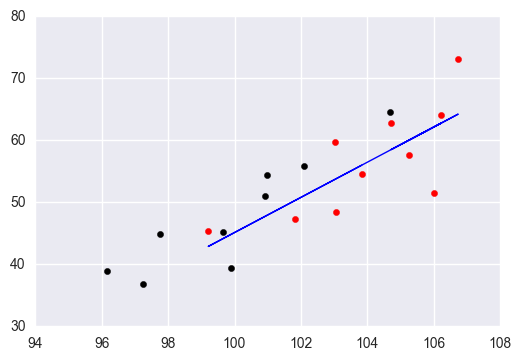

In [31]:
# split the data into training and test sets
kings_train2, kings_test2, no2_train2, no2_test2 = chronological_split(ds_merged_temp.kings_no2, ds_merged_temp.no2_ppb, test_size=0.5)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(reshape(no2_train2), reshape(kings_train2))
# co_train.values.shape
# The coefficients
print('Coefficients: \n', regr.coef_, regr.intercept_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regr.predict(reshape(no2_test2)) - reshape(kings_test2)) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(reshape(no2_test2), reshape(kings_test2)))
scores = cross_val_score(regr, reshape(no2_test2), reshape(kings_test2), scoring='r2')
print("R2 score: %.3f" % scores[0])

plt.scatter(no2_test2, kings_test2,  color='black')
plt.scatter(no2_train2, kings_train2, color='red')
plt.plot(reshape(no2_train2), regr.predict(reshape(no2_train2)), color='blue',
         linewidth=1)
plt.show()

       kings_no2  no2_ppb_modified
count  19.000000         20.000000
mean   52.392931         51.738310
std     9.749879          9.392256
min    36.768175         34.235062
25%    45.259812         44.662034
50%    51.498600         52.376859
75%    58.665725         58.882761
max    73.067325         66.063447
r2 score:  0.706619968235
Probability that they belong to the same distribution (KS p-value):  0.956292329188


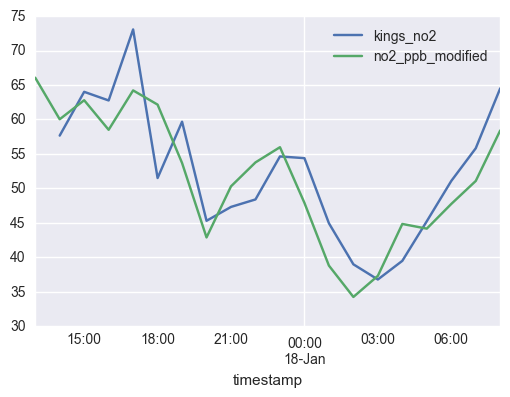

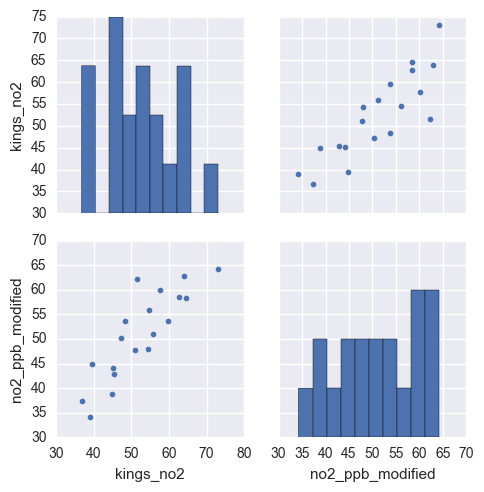

In [32]:
ds_merged['no2_ppb_modified'] = ds_merged['no2_ppb'] * regr.coef_[0] + regr.intercept_[0]
compare(ds_merged,'kings_no2','no2_ppb_modified')

## Fudge factors by fitting to the original formula

In [33]:
def convert_no2_model(raw_NO2, NO2_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV, NO2_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV, 
                     NO2_SENSITIVITY):
    NO2_PCB_GAIN= 0.8
    NO2_working_mv, NO2_aux_mv = raw_NO2
    temp_correction = 1.09
    scaled_working_NO2_nA = (NO2_working_mv - NO2_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV) / NO2_PCB_GAIN
    scaled_aux_NO2_nA  =  (NO2_aux_mv - NO2_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV) / NO2_PCB_GAIN * temp_correction
    return (scaled_working_NO2_nA - scaled_aux_NO2_nA) / NO2_SENSITIVITY

In [34]:
packed = ds_merged_temp[['raw_NO2_working', 'raw_NO2_aux']].T.values
packed

array([[ 128.69153247,  128.88919057,  128.47068437,  128.65093905,
         128.54444077,  128.13274074,  126.84877576,  127.31491987,
         127.556977  ,  127.84791742,  127.08204862,  126.43586813,
         125.94995405,  126.12692907,  126.43552714,  126.4384862 ,
         127.08102564,  127.47248485,  128.29478788],
       [ 123.31988012,  123.3244229 ,  123.21505754,  123.01458086,
         123.04890358,  123.21340337,  122.72691717,  122.67968215,
         122.67961154,  122.80532268,  122.61982284,  122.60959307,
         122.45512354,  122.4213653 ,  122.22256677,  122.26870303,
         122.62902964,  122.77457174,  123.05983471]])

In [35]:
no2_popt, no2_pcov = spo.curve_fit(convert_no2_model, packed, ds_merged_temp.kings_no2.values)

# compare fitted values to the given values
print("NO2_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV", no2_popt[0], " | real: ", NO2_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV)
print("NO2_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV", no2_popt[1], " | real: ", NO2_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV)
print("NO2_SENSITIVITY", no2_popt[2], " | real: ", NO2_SENSITIVITY)
# print("NO2_PCB_GAIN", no2_popt[3], " | real: ", str(0.8))

NO2_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV -11.2687323942  | real:  295
NO2_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV -0.88873313301  | real:  295
NO2_SENSITIVITY 0.0940503709751  | real:  -0.271


       no2_ppb_modified  kings_no2
count         19.000000  19.000000
mean          52.392931  52.392931
std            8.348559   9.749879
min           36.866982  36.768175
25%           46.375122  45.259812
50%           52.474739  51.498600
75%           59.315730  58.665725
max           64.660287  73.067325
r2 score:  0.63612211199
Probability that they belong to the same distribution (KS p-value):  0.999820414312


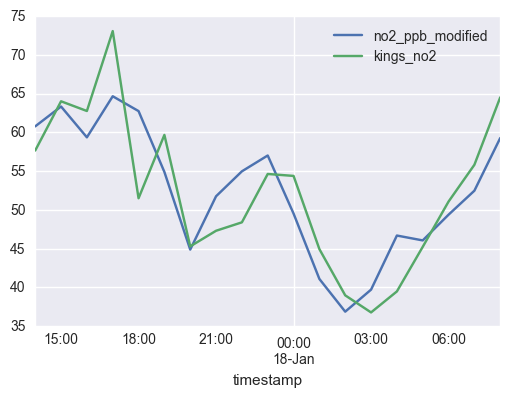

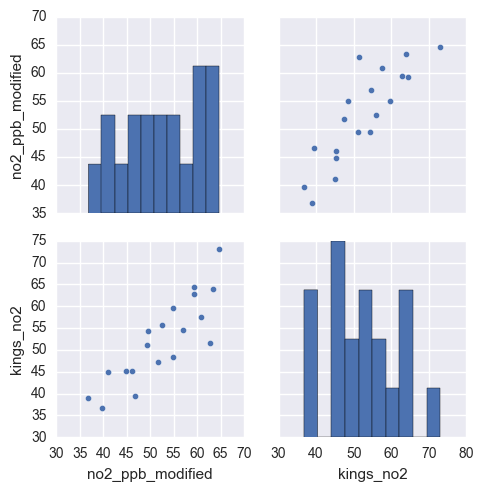

In [36]:
y = convert_no2_model(packed, *no2_popt)
y
ds_merged_temp['no2_ppb_modified'] = convert_no2_model(packed, *no2_popt)
compare(xr.Dataset.from_dataframe(ds_merged_temp), 'no2_ppb_modified', 'kings_no2')

## f1 score

In [37]:
# NO2 threshold taken from page 17 of http://apps.who.int/iris/bitstream/10665/69477/1/WHO_SDE_PHE_OEH_06.02_eng.pdf
NO2_WHO_THRESHOLD_MICROGRAMS = (40 + 200) / 2. # in micrograms per m3
NO2_WHO_THRESHOLD_PPB = NO2_WHO_THRESHOLD_MICROGRAMS / 1.88
NO2_WHO_THRESHOLD_PPB

63.829787234042556

In [38]:
# f1 score without any scaling or translation
# f1_score(no2_r2_df.dropna()['kings_no2'] > NO2_WHO_THRESHOLD_PPB, no2_r2_df.dropna()['no2_ppb'] > NO2_WHO_THRESHOLD_PPB)

In [39]:
# f1 score after some normalization
# f1_score(no2_r2_df.dropna()['kings_no2'] > NO2_WHO_THRESHOLD_PPB, no2_r2_df.dropna()['no2_ppb_modified'] > NO2_WHO_THRESHOLD_PPB)

# PM10

       kings_pm10        pm10
count   20.000000   20.000000
mean    58.368885   47.252279
std     11.370683   47.401765
min     43.119607   16.836222
25%     51.234482   22.076440
50%     55.703788   33.176817
75%     62.594729   38.825096
max     88.085102  215.159352
r2 score:  -20.9689521054
Probability that they belong to the same distribution (KS p-value):  1.52949753451e-06


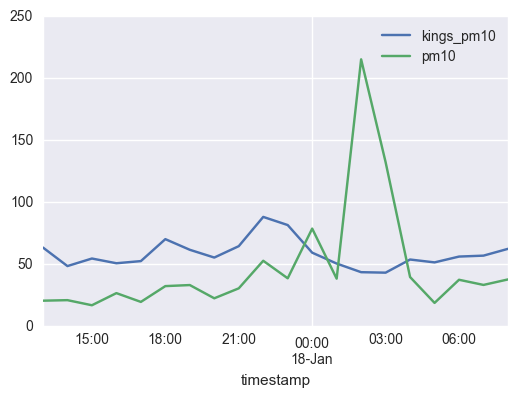

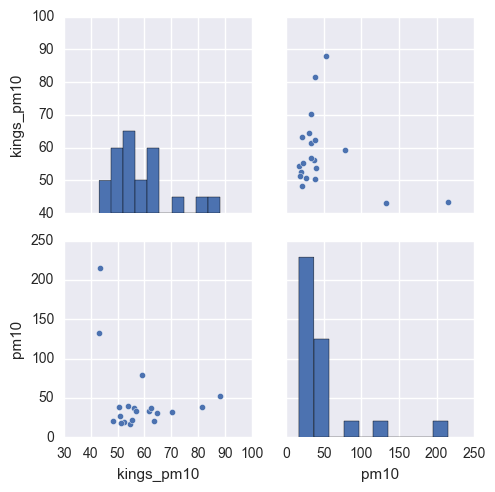

In [40]:
compare(ds_merged, 'kings_pm10', 'pm10')

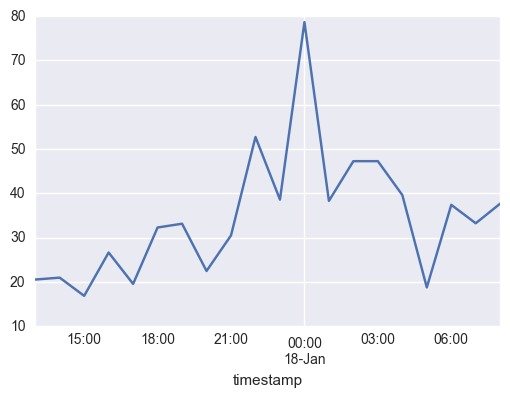

In [41]:
def remove_outliers(df, col):
    new_df = df.copy()
    outliers = (new_df[col] - new_df[col].median()).abs() > 1 * new_df[col].std()
    new_df.ix[new_df[col].notnull() & outliers, col] = new_df[col].mean()
    return new_df

new = remove_outliers(ds_merged.to_dataframe(), 'pm10')
ds_merged = xr.Dataset.from_dataframe(new)
new.pm10.plot()

In [42]:
# convenience function for reshaping for use in sklearn linear regression
def reshape(xarray_col):
    return xarray_col.values.reshape((len(xarray_col.values), 1))

def chronological_split(df_xcol, df_ycol, test_size=0.2):
    assert len(df_xcol) == len(df_ycol)
    test_number = int(test_size * len(df_xcol))
    train_number = len(df_xcol) - test_number
    return df_xcol.head(train_number), df_xcol.tail(test_number), df_ycol.head(train_number), df_ycol.tail(test_number)

def linear_regr_fudge(ds_merged, airpublic_measure, kings_measure, test_size=0.2, split='random'):
    if split not in ['random', 'chronological']:
        raise ValueError("splitting method should either be random or chronological")
    df_merged_temp = ds_merged.to_dataframe().dropna(subset=[kings_measure, airpublic_measure])
    if split == 'random':
        kings_train, kings_test, ap_train, ap_test = \
            train_test_split(df_merged_temp[kings_measure], df_merged_temp[airpublic_measure], test_size=test_size)
    else:
        kings_train, kings_test, ap_train, ap_test = \
            chronological_split(df_merged_temp[kings_measure], df_merged_temp[airpublic_measure], test_size=test_size)
    
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(reshape(ap_train), reshape(kings_train))
    # The coefficients
    print('Coefficients: \n', regr.coef_, regr.intercept_)
    # The mean squared error
    print("Mean squared error: %.2f"
          % np.mean((regr.predict(reshape(ap_test)) - reshape(kings_test)) ** 2))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % regr.score(reshape(ap_test), reshape(kings_test)))
    scores = cross_val_score(regr, reshape(ap_test), reshape(kings_test), scoring='r2')
    print("R2 score: %.3f" % scores[0])

    plt.scatter(ap_test, kings_test, color='black')
    plt.scatter(ap_train, kings_train, color='red')
    plt.plot(reshape(ap_train), regr.predict(reshape(ap_train)), color='blue',
             linewidth=1)
    plt.show()
    return regr.coef_, regr.intercept_

Coefficients: 
 [[-0.01041812]] [ 57.91733364]
Mean squared error: 261.42
Variance score: -0.08
R2 score: -0.065


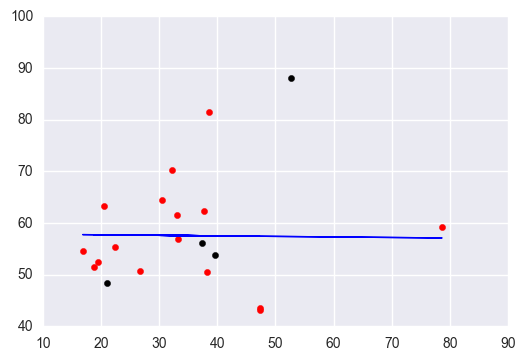

In [43]:
# random split
m, c = linear_regr_fudge(ds_merged, 'pm10', 'kings_pm10', test_size=0.2, split='random')

       pm10_modified  kings_pm10
count      20.000000   20.000000
mean       57.556791   58.368885
std         0.152614   11.370683
min        57.097851   43.119607
25%        57.512849   51.234482
50%        57.571694   55.703788
75%        57.687339   62.594729
max        57.741932   88.085102
r2 score:  -5610.03487094
Probability that they belong to the same distribution (KS p-value):  0.00072528603017


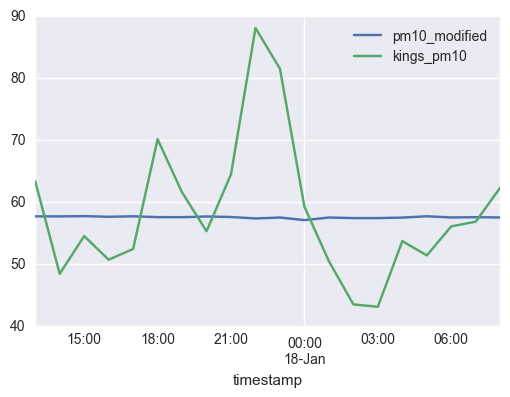

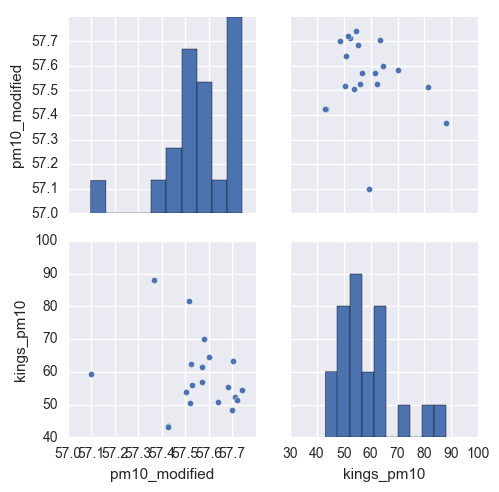

In [44]:
ds_merged['pm10_modified'] = ds_merged.pm10 * m[0][0] + c[0]
compare(ds_merged, 'pm10_modified', 'kings_pm10')

Coefficients: 
 [[ 0.13008067]] [ 54.19840583]
Mean squared error: 12.35
Variance score: 0.18
R2 score: -16.278


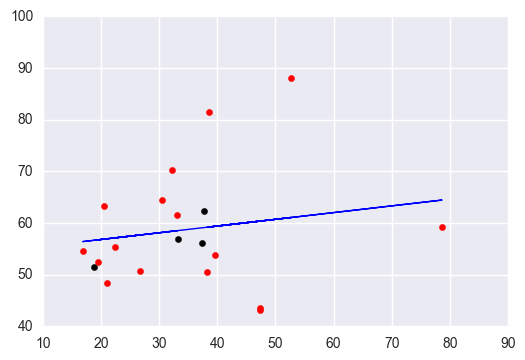

In [45]:
# chronological split
m, c = linear_regr_fudge(ds_merged, 'pm10', 'kings_pm10', test_size=0.2, split='chronological')

       pm10_modified  kings_pm10
count      20.000000   20.000000
mean       58.700147   58.368885
std         1.905540   11.370683
min        56.388473   43.119607
25%        57.070124   51.234482
50%        58.514068   55.703788
75%        59.248800   62.594729
max        64.430467   88.085102
r2 score:  -33.3110370818
Probability that they belong to the same distribution (KS p-value):  0.00257061430951


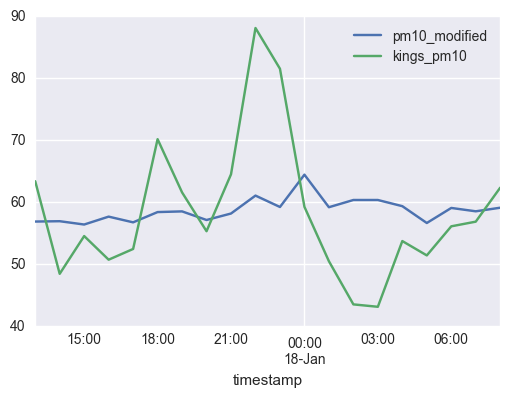

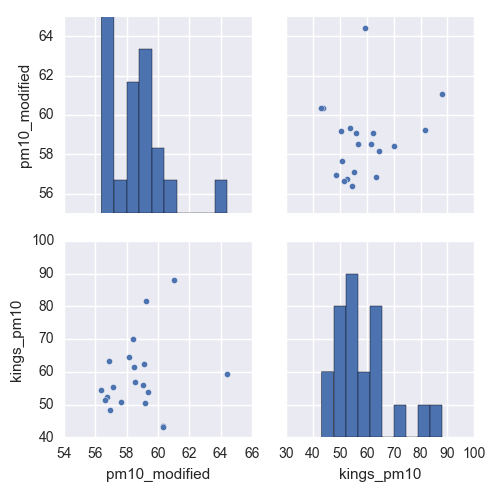

In [46]:
ds_merged['pm10_modified'] = ds_merged.pm10 * m[0][0] + c[0]
compare(ds_merged, 'pm10_modified', 'kings_pm10')

## Adjust for humidity (linear)

### Random split

In [47]:
ds_merged_outer = xr.merge([ds_kings_vol.rename(kings_prefix), ds_mean_1h]
                     , join='outer')

In [48]:
new = remove_outliers(ds_merged_outer.to_dataframe(), 'pm10')
ds_merged_outer = xr.Dataset.from_dataframe(new)

In [49]:
def humidity_o3_model(x, a, b, c):
    conc, humidity, ozone = np.array(x)
    real_conc = conc + a * humidity + b * ozone + c
    return real_conc

# drop nans
ds_merged_outer_temp = ds_merged_outer.to_dataframe().dropna(subset=['kings_o3', 'kings_pm10'])

# split the data into training and test sets
kings_train, kings_test, pm10_train, pm10_test, humidity_train, humidity_test, o3_train, o3_test = train_test_split(ds_merged_outer_temp.kings_pm10, ds_merged_outer_temp.pm10, ds_merged_outer_temp.humidity, ds_merged_outer_temp.kings_o3, test_size=0.2)
packed_values = pd.DataFrame([pm10_train, humidity_train, o3_train]).values
pm10_humidity_popt, pm10_humidity_pcov = spo.curve_fit(humidity_o3_model, packed_values, kings_train.values)
print("Humidity factor: {}".format(pm10_humidity_popt[0]))
print("Ozone factor: {}".format(pm10_humidity_popt[1]))

Humidity factor: -0.2068289701117562
Ozone factor: 0.950918269328094


       pm10_modified  kings_pm10
count       4.000000    4.000000
mean       64.081194   64.435680
std         9.049225   16.494748
min        55.756797   50.471937
25%        58.987213   55.255733
50%        61.916184   59.592841
75%        67.010165   68.772788
max        76.735612   88.085102
r2 score:  -0.269858223951
Probability that they belong to the same distribution (KS p-value):  0.99687568852


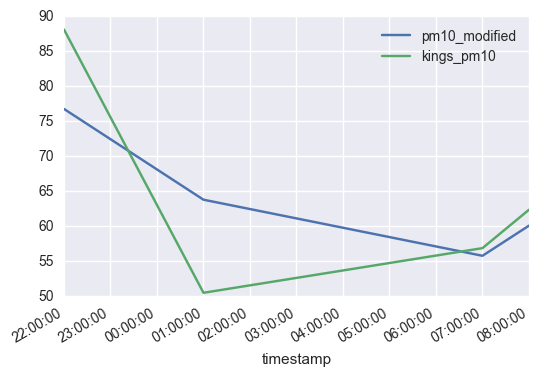

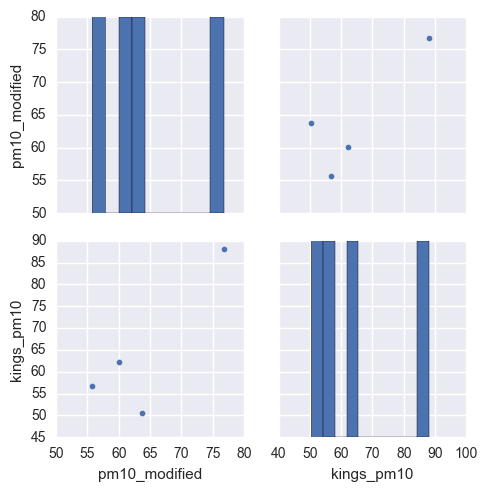

In [50]:
packed_test = pd.DataFrame([pm10_test, humidity_test, o3_test]).values
compare_test = pd.DataFrame({'pm10_modified': humidity_o3_model(packed_test, *pm10_humidity_popt)}, index=pm10_test.index)
compare_test['kings_pm10'] = kings_test
compare(xr.Dataset.from_dataframe(compare_test), 'pm10_modified', 'kings_pm10')

       pm10_modified  kings_pm10
count      19.000000   19.000000
mean       58.030889   58.105517
std         9.414489   11.619425
min        42.586036   43.119607
25%        52.205446   51.061748
50%        57.243250   55.308971
75%        63.785269   61.952299
max        76.735612   88.085102
r2 score:  -0.706168121054
Probability that they belong to the same distribution (KS p-value):  0.956292329188


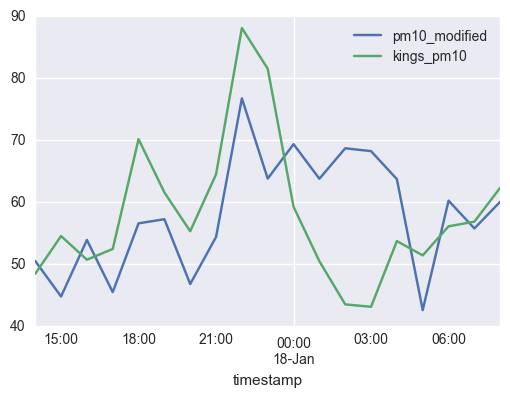

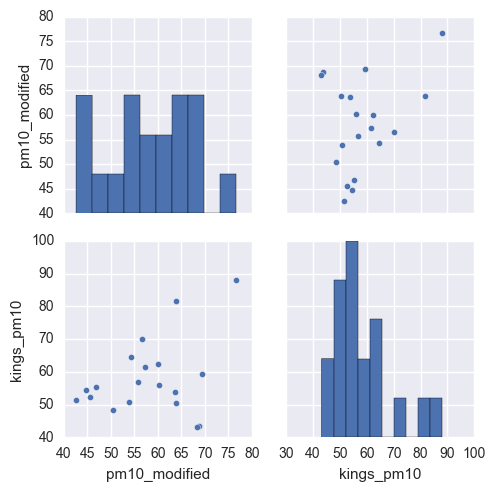

In [51]:
packed_all = pd.DataFrame([ds_merged_outer_temp.pm10, ds_merged_outer_temp.humidity, ds_merged_outer_temp.kings_o3]).values
compare_all = pd.DataFrame({'pm10_modified': humidity_o3_model(packed_all, *pm10_humidity_popt)}, index=ds_merged_outer_temp.pm10.index)
compare_all['kings_pm10'] = ds_merged_outer_temp.kings_pm10
compare(xr.Dataset.from_dataframe(compare_all), 'pm10_modified', 'kings_pm10')

### Chronological split

In [52]:
# split the data into training and test sets
kings_train2, kings_test2, pm10_train2, pm10_test2 = chronological_split(ds_merged_outer_temp.kings_pm10, ds_merged_outer_temp.pm10, test_size=0.3)
humidity_train2, humidity_test2, o3_train2, o3_test2 = chronological_split(ds_merged_outer_temp.humidity, ds_merged_outer_temp.kings_o3, test_size=0.3)

packed_values2 = pd.DataFrame([pm10_train2, humidity_train2, o3_train2]).values
pm10_humidity_popt2, pm10_humidity_pcov2 = spo.curve_fit(humidity_o3_model, packed_values2, kings_train2.values)
print("Humidity factor: {}".format(pm10_humidity_popt2[0]))
print("Ozone factor: {}".format(pm10_humidity_popt2[1]))

Humidity factor: 0.17601637811869217
Ozone factor: 5.158803416278127


       pm10_modified  kings_pm10
count       5.000000    5.000000
mean       60.509392   56.082298
std         8.800674    4.096575
min        45.080180   51.407216
25%        61.596575   53.719988
50%        64.297738   56.098606
75%        65.274755   56.850331
max        66.297714   62.335350
r2 score:  0.0994505222052
Probability that they belong to the same distribution (KS p-value):  0.208984830575


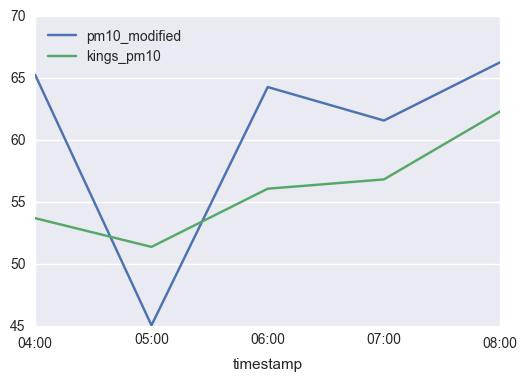

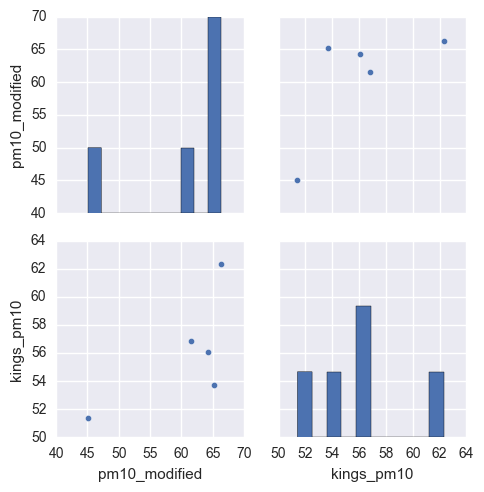

In [53]:
# plotting the test data
packed_test2 = pd.DataFrame([pm10_test2, humidity_test2, o3_test2]).values
compare_test = pd.DataFrame({'pm10_modified': humidity_o3_model(packed_test2, *pm10_humidity_popt2)}, index=pm10_test2.index)
compare_test['kings_pm10'] = kings_test2
compare(xr.Dataset.from_dataframe(compare_test), 'pm10_modified', 'kings_pm10')

       pm10_modified  kings_pm10
count      19.000000   19.000000
mean       59.270542   58.105517
std         9.774236   11.619425
min        41.632897   43.119607
25%        51.521976   51.061748
50%        61.596575   55.308971
75%        65.786235   61.952299
max        78.472800   88.085102
r2 score:  -0.605371224573
Probability that they belong to the same distribution (KS p-value):  0.246664385862


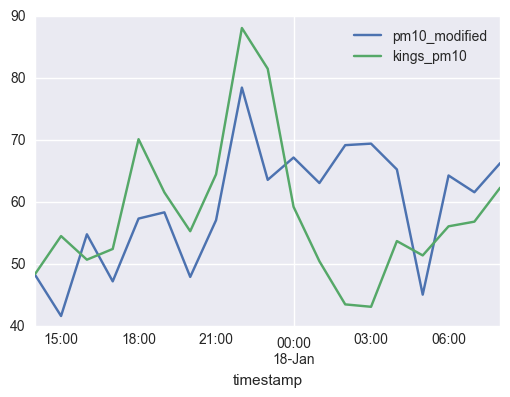

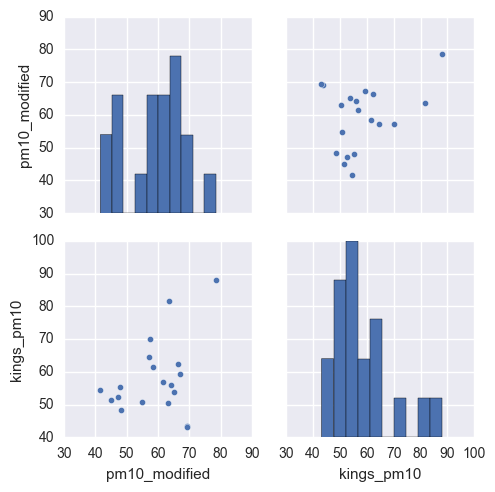

In [54]:
# plotting everything
packed_all2 = pd.DataFrame([ds_merged_outer_temp.pm10, ds_merged_outer_temp.humidity, ds_merged_outer_temp.kings_o3]).values
compare_all2 = pd.DataFrame({'pm10_modified': humidity_o3_model(packed_all, *pm10_humidity_popt2)}, index=ds_merged_outer_temp.pm10.index)
compare_all2['kings_pm10'] = ds_merged_outer_temp.kings_pm10
compare(xr.Dataset.from_dataframe(compare_all2), 'pm10_modified', 'kings_pm10')

## Adjust for humidity (inverse cubic)

Just trying this because intuitively since humidity measures the amount of particles in the air, and pm10 measures the volume of the particles, then pm10 should increase as $1/\text{(humidity)}^3$. Not sure if right though, just leaving this here.

### Random

In [55]:
def humidity_o3_model_cubic(x, a, b, c):
    conc, humidity, ozone = np.array(x)
    real_conc = conc + a * humidity**-3 + b * ozone + c
    return real_conc

# split the data into training and test sets
kings_train, kings_test, pm10_train, pm10_test, humidity_train, humidity_test, o3_train, o3_test = train_test_split(ds_merged_outer_temp.kings_pm10, ds_merged_outer_temp.pm10, ds_merged_outer_temp.humidity, ds_merged_outer_temp.kings_o3, test_size=0.2)
packed_values = pd.DataFrame([pm10_train, humidity_train, o3_train]).values
pm10_humidity_popt, pm10_humidity_pcov = spo.curve_fit(humidity_o3_model_cubic, packed_values, kings_train.values)
print("Humidity factor: {}".format(pm10_humidity_popt[0]))
print("Ozone factor: {}".format(pm10_humidity_popt[1]))

Humidity factor: -198492.34278181227
Ozone factor: 2.8398249402425804


       pm10_modified  kings_pm10
count      19.000000   19.000000
mean       56.681737   58.105517
std        11.095976   11.619425
min        36.332981   43.119607
25%        48.595911   51.061748
50%        58.957402   55.308971
75%        63.685729   61.952299
max        77.032652   88.085102
r2 score:  -0.344449858174
Probability that they belong to the same distribution (KS p-value):  0.741505714203


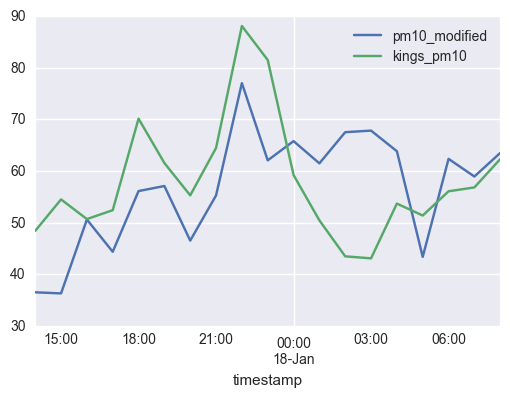

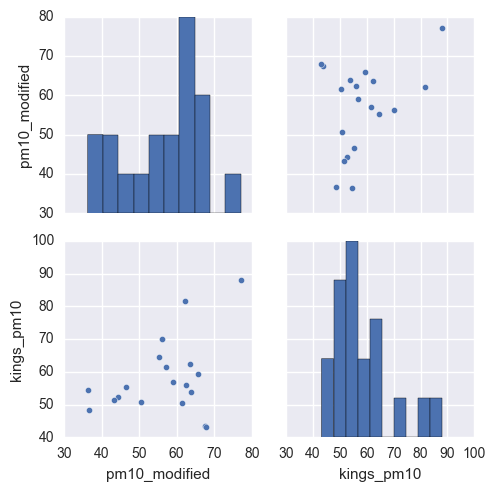

In [56]:
packed_all = pd.DataFrame([ds_merged_outer_temp.pm10, ds_merged_outer_temp.humidity, ds_merged_outer_temp.kings_o3]).values
compare_all = pd.DataFrame({'pm10_modified': humidity_o3_model_cubic(packed_all, *pm10_humidity_popt)}, index=ds_merged_outer_temp.pm10.index)
compare_all['kings_pm10'] = ds_merged_outer_temp.kings_pm10
compare(xr.Dataset.from_dataframe(compare_all), 'pm10_modified', 'kings_pm10')

### Chronological

In [57]:
# split the data into training and test sets
kings_train2, kings_test2, pm10_train2, pm10_test2 = chronological_split(ds_merged_outer_temp.kings_pm10, ds_merged_outer_temp.pm10, test_size=0.3)
humidity_train2, humidity_test2, o3_train2, o3_test2 = chronological_split(ds_merged_outer_temp.humidity, ds_merged_outer_temp.kings_o3, test_size=0.3)

packed_values2 = pd.DataFrame([pm10_train2, humidity_train2, o3_train2]).values
pm10_humidity_popt2, pm10_humidity_pcov2 = spo.curve_fit(humidity_o3_model_cubic, packed_values2, kings_train2.values)
print("Humidity factor: {}".format(pm10_humidity_popt2[0]))
print("Ozone factor: {}".format(pm10_humidity_popt2[1]))

Humidity factor: 67432.2295641685
Ozone factor: 0.44001261712631284


       pm10_modified  kings_pm10
count       5.000000    5.000000
mean       58.248819   56.082298
std         8.446730    4.096575
min        43.746844   51.407216
25%        58.095046   53.719988
50%        62.229865   56.098606
75%        62.529117   56.850331
max        64.643221   62.335350
r2 score:  0.239012208634
Probability that they belong to the same distribution (KS p-value):  0.208984830575


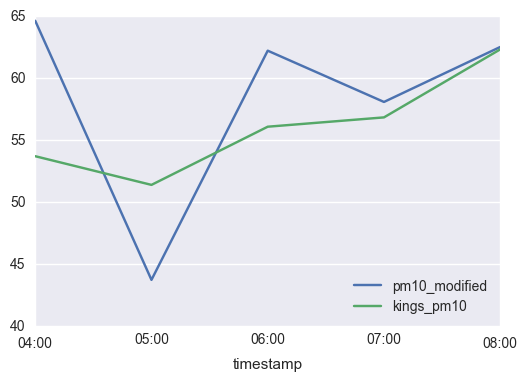

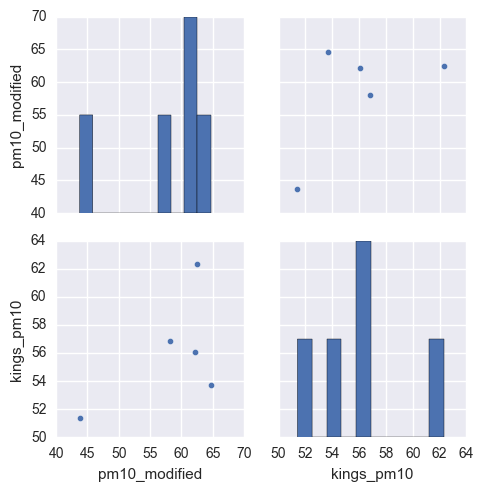

In [58]:
# plotting the test data
packed_test2 = pd.DataFrame([pm10_test2, humidity_test2, o3_test2]).values
compare_test = pd.DataFrame({'pm10_modified': humidity_o3_model_cubic(packed_test2, *pm10_humidity_popt2)}, index=pm10_test2.index)
compare_test['kings_pm10'] = kings_test2
compare(xr.Dataset.from_dataframe(compare_test), 'pm10_modified', 'kings_pm10')

       pm10_modified  kings_pm10
count      19.000000   19.000000
mean       58.675654   58.105517
std         9.580108   11.619425
min        43.746844   43.119607
25%        51.696945   51.061748
50%        58.157758   55.308971
75%        64.292262   61.952299
max        77.743461   88.085102
r2 score:  -0.63432834011
Probability that they belong to the same distribution (KS p-value):  0.46216806936


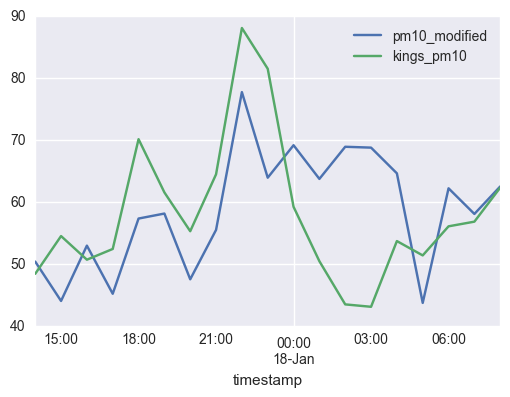

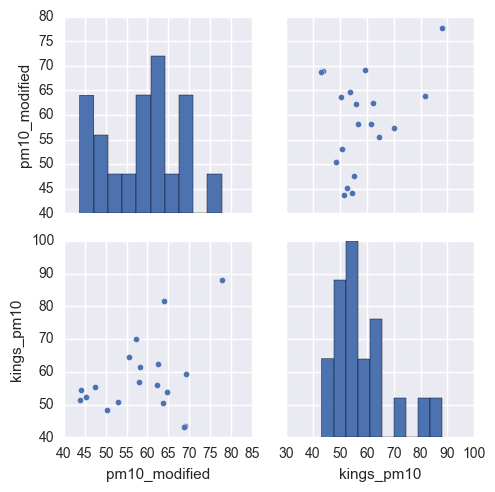

In [59]:
# plotting everything
packed_all2 = pd.DataFrame([ds_merged_outer_temp.pm10, ds_merged_outer_temp.humidity, ds_merged_outer_temp.kings_o3]).values
compare_all2 = pd.DataFrame({'pm10_modified': humidity_o3_model_cubic(packed_all, *pm10_humidity_popt2)}, index=ds_merged_outer_temp.pm10.index)
compare_all2['kings_pm10'] = ds_merged_outer_temp.kings_pm10
compare(xr.Dataset.from_dataframe(compare_all2), 'pm10_modified', 'kings_pm10')